How to use memory-fs and rewire to audit cli events?



In [ ]:
var path = require('path');var execSync = require('child_process').execSync;// TODO: use https://github.com/jhnns/rewire for replacing variables, something like https://github.com/mariocasciaro/object-path?var mockTypescriptFs = (root, data) => {    var mock = require('mock-require');    var memfs = require('memfs');    var mem = new memfs.Volume;    var unionfs = require('unionfs');    var fs = require('fs');    mem.mountSync(root, data);    // Create a union of two file systems:    unionfs        .use(fs)        .use(mem)        .replace(fs);    var ts = require('typescript');    var tsMock = Object.assign({}, ts);    var toMock = {        readFile: 'readFileSync',        realpath: 'realpathSync',        writeFile: 'writeFileSync',        fileExists: 'existsSync',        directoryExists: 'existsSync',        createDirectory: 'mkdirSync',        getDirectories: 'readdirSync'    };    Object.keys(toMock)        .forEach(k => {            if (typeof mem[toMock[k]] === 'function') {                tsMock.sys[k] = function () {                    // typescript.sys functions return defined on error                    try {                        return mem[toMock[k]].apply(mem, arguments);                    } catch (e) {                        return;                    }                };            }        });    mock('typescript', tsMock);    return mock;};mockTypescriptFs;// TODO: search github for projects like graceful-fs and then search google for projects that use graceful-fs and see if we can record some filesystem activity

In [ ]:
//mockTypescriptFs();

project word-cloud?



In [ ]:
var importer = require('../Core');var path = require('path');var projectWordCloud = (project) => {    var words = [];    var wordCount = function (r) {        var words = r['packages'].map(p => p.split('.ts/')[1])            .concat(r['packages'].map(p => path.basename(p.split('.ts/')[0])))            .concat(r['relatives'].map(r => path.basename(r)))            .concat(r['relatives'].map(r => path.basename(r.split('.ts/')[0])));        var wordCount = {};        words.forEach(w => {            if (typeof wordCount[w] === 'undefined') {                wordCount[w] = 15;            } else {                wordCount[w]++;            }        });        return Object.keys(wordCount).map((d) => ({text: d, size: wordCount[d]}));    };    return importer.import('relative paths and includes', {project})        .then(relativePaths => relativePaths(project))        .then(r => {            words = r;        })        .then(() => importer.import('d3.ipynb[create word-cloud]'))        .then(d3CloudToSVG => d3CloudToSVG(wordCount(words)));};module.exports = projectWordCloud;

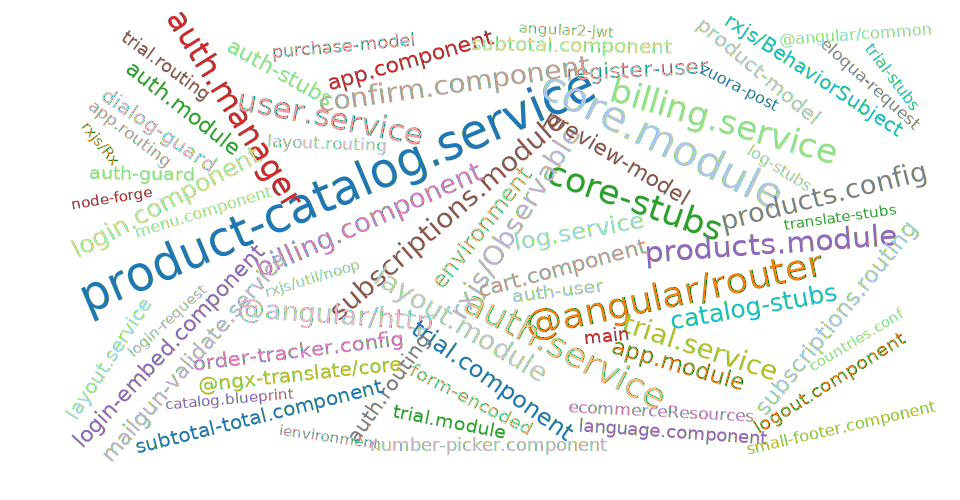

In [1]:
// TODO: create a gulp stream angular component out of it// TODO: connect with gulp-git https://www.npmjs.com/package/gulp-git// install https://github.com/Automattic/node-canvas/wiki/installation---osx// install using brew install pkg-config fontconfig cairo pixman giflib libjpeg libpng
var importer = require('../Core');var path = require('path');var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;var project = PROFILE_PATH + '/Documents/portal';$$.async()importer.import('file system.ipynb[project word-cloud]')
    .then(projectWordCloud => projectWordCloud(project))    .then(svg => $$.svg(svg))    .catch(e => $$.sendError(e));

project import to d3 tree?



In [ ]:
var importer = require('../Core');var path = require('path');
var wordCount = function (r) {
    var words = r['packages'].map(p => p.split('.ts/')[1])
        .concat(r['packages'].map(p => path.basename(p.split('.ts/')[0])))
        .concat(r['relatives'].map(r => path.basename(r)))
        .concat(r['relatives'].map(r => path.basename(r.split('.ts/')[0])));
    var wordCounts = {};
    words.forEach(w => {
        if (typeof wordCounts[w] === 'undefined') {
            wordCounts[w] = 1;
        } else {
            wordCounts[w]++;
        }
    });
    var resultWords = Object.keys(wordCounts).map((d) => ({name: d, size: wordCounts[d]}));
    var edges = [];
    r['packages'].forEach(
        p => edges[edges.length] = {source: p.split('.ts/')[1], target: path.basename(p.split('.ts/')[0])});
    r['relatives'].forEach(p => edges[edges.length] = {
        source: path.basename(p.split('.ts/')[0]),
        target: path.basename(p.split('.ts/')[1])
    });
    return {nodes: resultWords, edges: edges};
};
var projectTree = (project) => {    var words = [];    return importer.import('relative paths and includes', {project})        .then(projectRelatives => projectRelatives(project))        .then(r => {
            words = r;        })        .then(() => importer.import('d3.ipynb[display long tree]'))        .then(d3TreeToSVG => {
            var tree = wordCount(words);            return d3TreeToSVG(tree.nodes, tree.edges);        })
        .catch(e => console.log(e))};module.exports = projectTree;

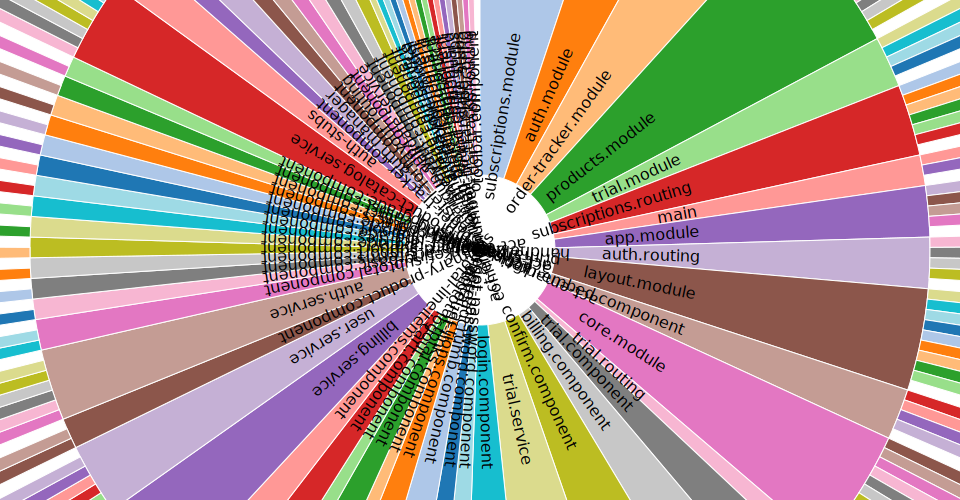

In [1]:
// TODO: create a gulp stream angular component out of it// TODO: connect with gulp-git https://www.npmjs.com/package/gulp-git// install https://github.com/Automattic/node-canvas/wiki/installation---osx// install using brew install pkg-config fontconfig cairo pixman giflib libjpeg libpngvar path = require('path');
var importer = require('../Core');var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;var project = PROFILE_PATH + '/Documents/portal';$$.async()
importer.import('file system.ipynb[project d3 tree]')    .then(projectTree => projectTree(project))    .then(svg => $$.svg(svg))    .catch(e => $$.sendError(e))

Find similar filename in project?



In [ ]:
var glob = require('glob');var findSimilarFile = (base, project) => {    return new Promise((resolve, reject) => {        var searchStrings = '**/' + base + '.ts';        console.log('Search for ' + searchStrings);        glob(searchStrings, {
            ignore: ['**/node_modules/**'],
            cwd: project
        }, function (err, matches) {            var isEmpty = matches.length == 0;            if (err) {                return reject(err);            } else if (isEmpty) {                console.log('No matches for ' + searchStrings)                return resolve();            }            // TODO: try to build and make sure it works before patching            resolve(matches[0].replace('.ts', ''));        });    });};module.exports = findSimilarFile;findSimilarFile;

Fix project paths?



In [6]:
var importer = require('../Core');var path = require('path');var gulp = require('gulp');var tap = require('gulp-tap');var replace = require('gulp-replace');// list all broken references in modules?var tasksToPromise, findSimilarFile;var projectRelatives = (project) => {    var missing, missingPackages;    var fixRelative = (m, match) => {        if (typeof m === 'undefined') {            return;        }        var file = m.split('.ts/')[0] + '.ts';        var fromPath = m.split('.ts/')[1];        var newRelative = path.relative(path.dirname(file), path.join(project, match));        gulp.task('fix include', function () {            var fixFile = path.relative(project, file);            console.log('Replacing ' + fromPath + ' -> ' + newRelative + ' in ' + fixFile)            return gulp.src(['**/' + fixFile], {cwd: project})                .pipe(replace(fromPath, newRelative))                .pipe(gulp.dest(project));        });        return tasksToPromise(['fix include'], []);    };    var uniqueArray = (arr) => arr.filter((value, index, array) => array.indexOf(value, index + 1) < 0);    gulp.task('add packages', function () {        var toAdd = '';        return gulp.src('package.json', {cwd: project})            .pipe(tap(file => {                // TODO: resolve using existing package.json from another project?  This method of using the import isn't going to go far, how does NPM do this?                // Possible to search for top two directories? @angular/material versus angular2-jwt versus zone.js/dist/zone                var content = file.contents.toString();                missingPackages.map(p => p.split('.ts/')[1].forEach(m => {                    if (content.indexOf(m) === -1) {                        toAdd += '"' + m + '": "latest",'                    }                }));                if (toAdd !== '') {                    console.log('Adding ' + toAdd);                    file.contents = new Buffer(content.replace(/"dependencies"\s*:\s*\{/ig, (m) => m + toAdd));                }            }))            .pipe(gulp.dest(project));    });    return importer.import([        'relative paths and includes',        'task to promise',        'similar filename in project'    ], {gulp})        .then(r => {            tasksToPromise = r[1];            findSimilarFile = r[2];            return r[0];        })        .then(r => r['getRelativeImports'](project))        .then(r => {            missing = r['missing'];            missingPackages = r['missingPackages'];            return Promise.all(Object.keys(missing).map(k => findSimilarFile(k, project).then(f => {                if (typeof f === 'undefined') {                    return Promise.resolve();                }                return Promise.all(missing[k].map(m => fixRelative(m, f)));            })));        })        .then(r => tasksToPromise(['add packages']));    // TODO: try building with all results resolved    // TODO: create path and apply};module.exports = projectRelatives;

[Function: projectRelatives]

List files in a project excluding some excessive searches locations?



In [ ]:
var glob = require('glob');var path = require('path');// But we also want to automatically load projects?var listInProject = (root, match = '**/package.json') => {    return new Promise((resolve, reject) => {        glob(match, {            ignore: ['**/node_modules/**',                '**/packages/**',                '**/vendor/**',                '/Users/**/Downloads/**',                '/Users/**/Library/**',                '/Users/**/Applications/**',                '/Users/**/Music/**',                '**/wp-content/**',                '**/wp-includes/**',                '**/Pods/**',                '**/svn/**',                '**/.git/**',                '**/.vscode/**',                '**/.npm/**',                '**/\\.*',                '**/.*',                '**/Cache/**',                '**/Creative Cloud Files/**'],            cwd: path.resolve(root),            silent: true,            nodir: true,            strict: false        }, (err, matches) => {            if (err) {                return reject(err);            }            return resolve(matches);        });    })        .then(matches => matches.map(m => path.join(root, m)));};module.exports = listInProject;listInProject;

List projects by name?



In [ ]:
// But we also want to automatically load projects?var listProjects = (root, match = '**/package.json') => {    listInProject        .then(matches => matches.forEach(m => {            var projectPath = path.dirname(path.join(root, m));            result[path.basename(projectPath)] = projectPath;        }));};module.exports = listProjects;listProjects;

De-lint notebook cells automatically?

Find too long of functions using regexp?
(?=\{((?:[^{}]++|\{(?1)\})++)\})

Export all notebooks to a structured folder where each cell has it's own file for linting?

Import files back in to cells? (two-way workflow)



In [8]:
var importer = require('../Core');var gulp = require('gulp');var tap = require('gulp-tap');var XRegExp = require('xregexp');// How to convert a string to an Array of RegEx matchesvar regexToArray = (ex, str, i = 0) => {    var co = [];    var m;    while ((m = re.exec(str)) && co.push(m[i])) ;    return co;};var matchCurlyBraces = (contents) => {    var newMatches = XRegExp.matchRecursive(contents, '{', '}', 'gi', {        valueNames: ['literal', null, 'value', null]    }).filter(m => m.name === 'value');    //console.log(newMatches);    return newMatches.reduce(        (arr, m) => arr.concat(matchCurlyBraces(m.value)),        newMatches);};var findLongFunctions = (project) => {    var results = [];    gulp.task('find long functions', function () {        return gulp.src('**/*.+(ts|js|cs)', {            ignore: ['**/node_modules/**',                '**/dist/**',                '**/typings/**',                '**/packages/**',                '**/*.spec*',                '**/*.Tests/**'            ], cwd: project        })            .pipe(tap(file => {                const contents = file.contents.toString();                try {                    results = results.concat(matchCurlyBraces(contents)                        .map(m => Object.assign(m, {path: file.path})));                } catch (e) {                    results = results.concat([{                        name: 'value',                        value: file.contents.toString(),                        start: 0,                        end: file.contents.length,                        error: e,                        path: file.path                    }]);                }            }));    });    return importer.import('task to promise', {gulp})        .then(tasksToPromise => tasksToPromise('find long functions'))        .then(() => {            var code = results.map(r => r.value);            var topLevel = results                .filter(r => code                    .filter(c => c !== r.value && c.indexOf(r.value) > 0).length === 0);            results = results                .filter(m => topLevel.filter(c => c.value === m.value).length === 0);            code = results.map(r => r.value);            topLevel = topLevel.concat(results.filter(r => code                .filter(c => c !== r.value && c.indexOf(r.value) > 0).length === 0));            results = results                .filter(m => topLevel.filter(c => c.value === m.value).length === 0);            return results                .filter(m => m.value.split(/\n/ig).length > 100)        });};module.exports = findLongFunctions;var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;var project = PROFILE_PATH + '/Documents/asm/subscription.identitymanagement';$$.async();findLongFunctions(project)    .then(e => $$.sendResult(e.map(m => m.path)))    .catch(e => $$.sendError(e));

Already imported
[ 'import notebook.ipynb', 'interpret all notebooks.ipynb' ]


[ '/Users/briancullinan/Documents/asm/subscription.identitymanagement/Subscription.IdentityManagement/IdentityServer/Clients.cs',
  '/Users/briancullinan/Documents/asm/subscription.identitymanagement/Subscription.IdentityManagement/IdentityServer/Clients.cs' ]